In [167]:
from nutils import function, mesh, solver
from nutils.expression_v2 import Namespace
import numpy as np
from matplotlib import pyplot as plt
from consts import *
import scipy.linalg as la

plt.style.use("default")
def find_region(value):
    r1 = consts["r1"]
    r2 = consts["r2"]
    r3 = consts["r3"]
    r4 = consts["r4"]

    # 判断值落在哪个区间
    if 0 <= value < r1: 
        return int(0)
    elif r1 <= value < r2:
        return int(1)
    elif r2 <= value < r3:
        return int(2)
    elif r3 <= value <= r4:
        return int(3)
    else:
        raise ValueError("Value {} is less than 0 or larger than r4".format(value))


class exact_fn():
    def __init__(self,):
        self.name = "RHS"
        self.scale = [0, 1]
        self.mu = 1
        self.mu0 = 1.257*10**-6 # H/m
        self.Jz = -1326291.1924324587
        self.B0 = -0.0001302459397568438
        self.A0 = -0.0006358641469510412

 
    def __call__(self, x):
        # 检查x是否为单个数字，如果是，将其转换为一个元素的数组
        single_value = np.isscalar(x)
        if single_value:
            x = np.array([x])

        result = np.zeros_like(x, dtype=float)
        for i in range(len(x)):
            x_ = x[i]
            region = find_region(x_)
            Param = consts["Params"][region]
            self.A0 = Param["A"]
            self.B0 = Param["B"]
            self.mu = Param["mu"]
            self.Jz = Param["Jz"]
            self.muJz = self.mu * self.mu0 * self.Jz
            if x_ != 0:
                # func1 = A0 - 1/4 * muJz * x_**2 
                func1 = self.A0 + self.B0*np.log(x_) - 1/4 * self.muJz * x_**2 
            else:
                # func1 = A0 + B0*np.log(x_) - 1/4 * muJz * x_**2 
                func1 = self.A0 - 1/4 * self.muJz * x_**2 
            result[i] = func1

        # 如果输入是单个数字，返回单个结果，否则返回数组
        return result[0] * 1e6 if single_value else result * 1e6

In [168]:


def assemble(M_1, M_2):
    # 检查 M_1 是否为矩阵
    if M_1.ndim == 2:
        # 计算新矩阵的大小
        size_new = (M_1.shape[0] + M_2.shape[0] - 1, M_1.shape[1] + M_2.shape[1] - 1)
        new_M = np.zeros(size_new)
        # 填充 M_1 的部分
        new_M[:M_1.shape[0], :M_1.shape[1]] += M_1
        # 填充 M_2 的部分，确保重叠区域值相加
        new_M[M_1.shape[0]-1:, M_1.shape[1]-1:] += M_2
        
    # 检查 M_1 是否为向量
    elif M_1.ndim == 1:
        # 计算新向量的长度
        length_new = (M_1.shape[0] + M_2.shape[0] - 1, 1)
        new_M = np.zeros(length_new)
        # 填充 M_1 的部分
        new_M[:M_1.shape[0]] += M_1.reshape(-1, 1)
        # 填充 M_2 的部分，确保重叠区域值相加
        new_M[M_1.shape[0]-1:] += M_2.reshape(-1, 1)
        
    else:
        raise ValueError("M_1 must be either a matrix (2D array) or a vector (1D array).")
        
    return new_M



def creat_mesh(num_elems_per_segment = 1  ):
    # 初始化网格数组
    interfaces = interfaces_global
    mesh = np.array([])

    # 遍历界面列表，为每个子区间生成网格
    for i in range(len(interfaces)-1):
        # 当前子区间的起始点和结束点
        start, end = interfaces[i], interfaces[i+1]

        # 在当前子区间内生成等间距的节点
        # np.linspace包括区间的起始和结束点，但为避免重复添加界面节点，我们从第二个节点开始添加（当i不为0时）
        sub_mesh = np.linspace(start, end, num_elems_per_segment + 1)
        if i > 0:
            sub_mesh = sub_mesh[1:]  # 移除子网格的第一个节点，因为它是上一个子网格的最后一个节点

        # 将子网格添加到总网格中
        mesh = np.concatenate((mesh, sub_mesh))
        
    mesh_lst = []
    interfaces = interfaces_global

    # 遍历界面列表，为每个子区间生成网格
    for i in range(len(interfaces)-1):

        this_mesh = np.linspace(interfaces[i], interfaces[i+1], num_elems_per_segment+1)
        mesh_lst.append((this_mesh))

    return mesh, mesh_lst

    

mesh_global, mesh_global_lst = creat_mesh(1)
print(mesh_global)

mesh.rectilinear([mesh_global])
topo, geom = mesh.rectilinear([mesh_global])

topo.boundary['left']
basis = topo.basis('spline', degree=1)
print(basis.shape)

[0.   0.01 0.01 0.01 0.01]
(5,)


In [169]:
def K_F_subdomain(submesh):
    # print(submesh)
    topo, geom = mesh.rectilinear([submesh])
    ns = Namespace()
    ns.x = geom
    ns.define_for('x', gradient='∇', normal='n', jacobians=('dV', 'dS'))
    ns.basis = topo.basis('spline', degree=1)
    ns.u = function.dotarg('lhs', ns.basis)
    M = topo.integral('x_0 ∇_i(basis_m) ∇_i(basis_n) dV' @ ns, degree=1).eval()
    K = M.export('dense')
    F = topo.integral('x_0 basis_m dV' @ ns, degree=1).eval().reshape(-1, 1)

    return K, F

def FEM(mesh_global_lst, verbose = False):


    K_lst = []
    F_lst = []

    for i in range(len(mesh_global_lst)):
        Params = consts["Params"][i]
        mu = Params["mu"]
        Jz = Params["Jz"]
        print(mu, Jz)

        K_sub, F_sub = K_F_subdomain(mesh_global_lst[i])
        K_sub /= mu
        F_sub *= Jz
        
        K_lst.append(K_sub)
        F_lst.append(F_sub)
        print("Fsub:", F_sub)
        if i == 0:
            K = K_sub
            F = F_sub
        else:
            K = assemble(K, K_sub)
            F = assemble(F, F_sub)
    K[-1, -1] = 1
    K[-1,  0:-1] = 0.0
    # K[0:-1,  -1] = 0.0
    F[-1] = 0
    U = la.solve(K, F)
    if verbose:
        np.set_printoptions(precision=2, suppress=True)
        print("K:\n", K)
        print("F:\n", F)

    return K, F, U



1 0
Fsub: [[0.]
 [0.]
 [0.]]
1 2744050.7429637127
Fsub: [[3.81]
 [7.96]
 [4.15]]
10 0
Fsub: [[0.]
 [0.]
 [0.]]
1 -1501461.7272820305
Fsub: [[-3.89]
 [-7.96]
 [-4.07]]
K:
 [[  0.5   -0.5    0.     0.     0.     0.     0.     0.     0.  ]
 [ -0.5    2.    -1.5    0.     0.     0.     0.     0.     0.  ]
 [  0.    -1.5   12.6  -11.1    0.     0.     0.     0.     0.  ]
 [  0.     0.   -11.1   23.2  -12.1    0.     0.     0.     0.  ]
 [  0.     0.     0.   -12.1   12.48  -0.38   0.     0.     0.  ]
 [  0.     0.     0.     0.    -0.38   0.86  -0.48   0.     0.  ]
 [  0.     0.     0.     0.     0.    -0.48  21.18 -20.7    0.  ]
 [  0.     0.     0.     0.     0.     0.   -20.7   42.4  -21.7 ]
 [  0.     0.     0.     0.     0.     0.     0.     0.     1.  ]]
F:
 [[ 0.  ]
 [ 0.  ]
 [ 3.81]
 [ 7.96]
 [ 4.15]
 [ 0.  ]
 [-3.89]
 [-7.96]
 [ 0.  ]]
[76.84]


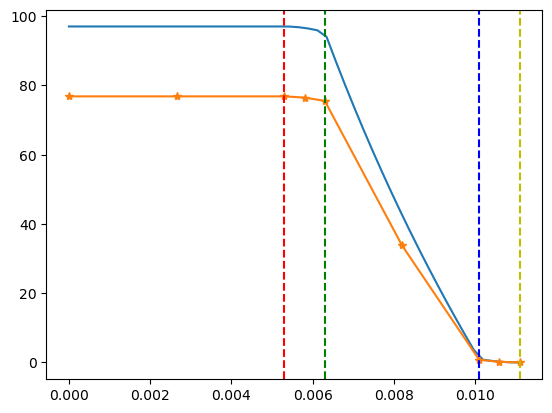

In [170]:
verbose = True
num_elems = 2

mesh_global, mesh_global_lst = creat_mesh(num_elems)
K, F, U = FEM(mesh_global_lst, verbose)
exact_func = exact_fn()
x_global = np.linspace(0, 0.0111, 50)
u_exact = exact_func(x_global)
plt.plot(x_global, u_exact)
plt.plot(mesh_global, U, "*-")

r1 = consts["r1"]
r2 = consts["r2"]
r3 = consts["r3"]
r4 = consts["r4"]
plt.axvline(x=r1, color='r', linestyle='--', label='r1')  # 红色虚线
plt.axvline(x=r2, color='g', linestyle='--', label='r2')  # 绿色虚线
plt.axvline(x=r3, color='b', linestyle='--', label='r3')  # 蓝色虚线
plt.axvline(x=r4, color='y', linestyle='--', label='r4')  # 黄色虚线
# plt.ylim(0, 1)
print(U[0])
